In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

import re

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
import warnings; warnings.simplefilter('ignore')

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#pip install sklearn

In [3]:
# Read the data
classified_data = pd.read_csv("final_data.csv",  sep=';')
# Clean data
classified_data.replace([np.inf, -np.inf], np.nan, inplace=True)
classified_data = classified_data.dropna()
classified_data.avis1 = classified_data.avis1.astype(int)

In [4]:
classified_data

,avis1,text,id
0,1,Elle ne devait pas dégager la nazi ??? https:/...,1.466478e+18
1,0,je dois faire un oral en anglais sur Hitler et...,1.466478e+18
2,0,@ambrassmoi_ A ça 🤏 de ressembler à la croix n...,1.466478e+18
3,0,"Par curiosité, j’ai voulu écouter les discours...",1.466478e+18
4,1,@tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...,1.466478e+18
...,...,...,...
2851,1,Kevin c’est un sal noir.,1.464411e+18
2852,1,"bougnoule bamboula sale arabe , elle est belle...",1.464364e+18
2853,1,@B_mahrezz Tu viens de le traiter de sal noir ?,1.464234e+18
2854,1,SAL NOIR https://t.co/JraABFtel8,1.463961e+18


In [5]:
classified_data['avis1'].value_counts()

0    1851
1    1005
Name: avis1, dtype: int64

**CLEAN DATA**

In [6]:
# all the tweets
text = list(classified_data['text'])

In [7]:
import nltk
from  nltk.stem.snowball import FrenchStemmer

def generate_stopwords():
    stopwords_fr = nltk.corpus.stopwords.words("french")
    stop_words = stopwords_fr
    other_exclusions = ["les"]
    stop_words.extend(other_exclusions)
    return stop_words

In [8]:
stopwords = generate_stopwords()

In [9]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

In [10]:
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+"," ",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", " ", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", " ").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = re.sub(r'[^\w\s]',' ',tweet)
    final_tweet = emoji_pattern.sub(r'', tweet) #Remove all emojis
#     remove stopwords
    querywords = final_tweet.split()
    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    result = ' '.join(resultwords)
    return result

In [11]:
# Apply function cleaner to list of string (text)
map_object = map(cleaner, text)
cleaned_text = list(map_object)
final_text = list(map(lambda x: x.lower(), cleaned_text))

In [15]:
final_df = pd.DataFrame(final_text, columns=["Cleaned Tweets"])
classements = classified_data['avis1']
final_df['Classement'] = classements
final_df

,Cleaned Tweets,Classement
0,devait dégager nazi,1
1,dois faire oral anglais hitler propagande sect...,0
2,a ça ressembler croix nazi mdrr,0
3,curiosité voulu écouter discours longs hitler ...,0
4,mdr deux nazi importe quoi,1
...,...,...
2851,kevin sal noir,1
2852,bougnoule bamboula sale arabe belle france jui...,1
2853,mahrezz viens traiter sal noir,1
2854,sal noir,1


**EMBEDDING WITH BERT**

Import

In [16]:
# pip install torch torchvision
# pip install transformers==4.15.0
# pip install sentence-transformers
# pip install ipywidgets

In [20]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [21]:
sentence_embeddings = model.encode(final_text)

In [22]:
sentence_embeddings.shape

(2856, 512)

In [23]:
# for sentence, embedding in zip(final_text, sentence_embeddings):
#     print("Sentence:", sentence)
#     print("Embedding:", embedding)
#     print("")

In [24]:
# x_train + x_test
bert_df = pd.DataFrame(sentence_embeddings)
bert_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.040990,0.014742,0.014450,-0.032188,-0.001382,-0.113907,-0.044004,0.043807,-0.050006,0.070010,...,-0.000834,0.017572,0.074853,-0.028266,-0.037651,0.021778,-0.012675,0.037532,0.073124,0.002818
1,-0.037154,-0.026686,0.058250,0.016171,0.044538,-0.083136,-0.034722,0.044099,-0.074935,0.012267,...,-0.025437,-0.039688,0.020507,0.013756,-0.003722,0.038629,0.026163,-0.029775,0.055509,-0.030264
2,-0.043957,-0.067542,0.069085,-0.017325,0.008731,-0.032363,-0.049847,-0.024525,-0.014037,0.027650,...,0.018029,0.080830,0.112252,-0.037111,-0.025388,0.003308,0.008781,0.001898,-0.020053,0.039027
3,-0.017678,0.018229,-0.031099,-0.036380,0.043640,-0.032819,0.082148,0.002441,-0.047859,-0.002672,...,0.004251,0.048585,-0.002496,0.040308,-0.001020,-0.039168,-0.022797,0.006239,0.056398,-0.078273
4,0.000087,-0.035987,0.014659,-0.058293,0.008797,-0.097896,-0.034231,-0.035488,-0.048830,-0.079534,...,0.046544,0.080474,0.097768,-0.009490,-0.021601,0.013435,-0.001842,-0.007572,0.056244,-0.027716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851,0.045091,0.054384,0.028243,0.011641,0.018075,-0.035164,-0.004422,-0.010421,0.050437,0.021943,...,0.060232,-0.040102,0.023010,-0.020926,-0.039301,0.035150,-0.008535,-0.032618,0.028431,0.013416
2852,0.022828,0.045928,0.029991,-0.021987,0.042904,-0.081769,-0.010283,0.000887,0.044637,0.048189,...,0.024196,-0.017525,0.006251,-0.020748,0.032192,0.006308,0.064069,-0.032920,0.041429,-0.015009
2853,0.027547,0.036749,0.005985,0.017871,0.024609,-0.075670,-0.021503,-0.007337,0.040387,0.007286,...,0.110434,0.018604,0.015221,-0.021720,-0.031503,0.011623,-0.034953,-0.006035,0.052841,0.010131
2854,0.027365,0.046461,-0.008071,-0.013620,-0.023218,-0.039475,0.011383,-0.010844,0.018849,-0.013087,...,0.055492,-0.009762,0.005501,-0.014515,-0.043474,0.002562,-0.031522,-0.023956,0.090468,-0.007074


In [25]:
# Split Data to train and test parts
y = final_df["Classement"]
X_train, X_test, y_train, y_test = train_test_split(bert_df, y, test_size=0.2, random_state=42)

## Random Forest

In [26]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

RandomForestClassifier()

In [27]:
y_pred = random_forest_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test,y_pred))

Accuracy: 0.7692307692307693


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84       375
           1       0.82      0.42      0.56       197

    accuracy                           0.77       572
   macro avg       0.79      0.69      0.70       572
weighted avg       0.78      0.77      0.75       572



In [29]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred).ravel())
# TN FP FN TP

Confusion Matrix:
[357  18 114  83]


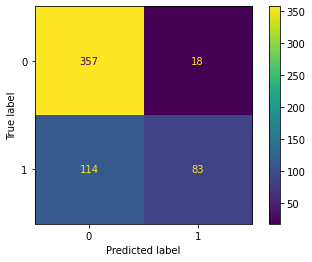

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(random_forest_model, X_test, y_test)

## Logistic Regression

In [48]:
logistic_regression_model = LogisticRegression().fit(X_train, y_train)

In [49]:
y_pred_LR = logistic_regression_model.predict(X_test)
logistic_regression_model.score(X_test, y_test)

0.7604895104895105

In [50]:
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       375
           1       0.70      0.54      0.61       197

    accuracy                           0.76       572
   macro avg       0.74      0.71      0.72       572
weighted avg       0.75      0.76      0.75       572



In [51]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_LR).ravel())

Confusion Matrix:
[329  46  91 106]


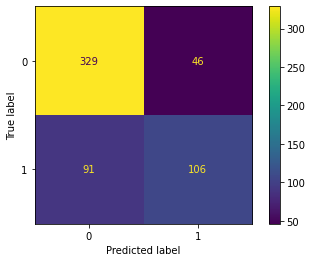

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logistic_regression_model, X_test, y_test)

## XGBOOST

In [36]:
xgboost_model = GradientBoostingClassifier().fit(X_train, y_train)

In [37]:
y_pred = xgboost_model.predict(X_test)
xgboost_model.score(X_test, y_test)

0.7604895104895105

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       375
           1       0.71      0.51      0.59       197

    accuracy                           0.76       572
   macro avg       0.74      0.70      0.71       572
weighted avg       0.75      0.76      0.75       572



In [39]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred).ravel())

Confusion Matrix:
[335  40  97 100]


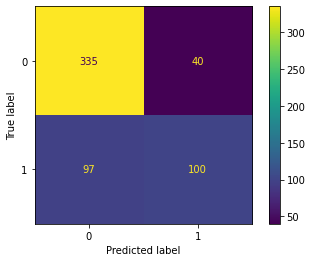

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgboost_model, X_test, y_test)